# EasyVVUQ fusion tutorial

Run an EasyVVUQ campaign to analyze the sensitivity of the temperature
profile predicted by a simplified model of heat conduction in a
tokamak plasma.

This is done with PCE.

In [1]:
!pip install EasyVVUQ
!pip install future
!pip install fipy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 188 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 10 kB/s  eta 0:00:01:00:05  | 10.4 MB 3.8 MB/s eta 0:00:05          | 12.7 MB 3.8 MB/s eta 0:00:04/s eta 0:00:02�████████████       | 21.4 MB 9.6 MB/s eta 0:00:01
Processing /home/jovyan/.cache/pip/wheels/bf/9c/85/e568170c957265441b246799a8cd4c6d996ae7509dd42bafa8/SALib-1.3.12-py2.py3-none-any.whl
     |████████████████████████████████| 889 kB 30.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 60 kB/s s eta 0:00:01               | 4.8 MB 22.4 MB/s eta 0:00:01
Processing /home/jovyan/.cache/pip/wheels/b1/f5/ee/9c072cedde5286a5f4b27e07269ad83a67878ff249794c8c97/pytest_pep8-1.0.6-py3-none-any.whl
  Using cached kubernetes-12.0.1-py2.py3-none-any.whl (1.7 MB)
Processing /home

In [2]:
# import packages that we will use

import os
import easyvvuq as uq
import chaospy as cp
import pickle
import time
import numpy as np 
import matplotlib.pylab as plt

In [3]:
# Set up a fresh campaign called "fusion_pce."

my_campaign = uq.Campaign(name='fusion_pce.')

In [4]:
# Define parameter space

params = {
    "Qe_tot":   {"type": "float",   "min": 1.0e6, "max": 50.0e6, "default": 2e6}, 
    "H0":       {"type": "float",   "min": 0.00,  "max": 1.0,    "default": 0}, 
    "Hw":       {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 0.1}, 
    "Te_bc":    {"type": "float",   "min": 10.0,  "max": 1000.0, "default": 100}, 
    "chi":      {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 1}, 
    "a0":       {"type": "float",   "min": 0.2,   "max": 10.0,   "default": 1}, 
    "R0":       {"type": "float",   "min": 0.5,   "max": 20.0,   "default": 3}, 
    "E0":       {"type": "float",   "min": 1.0,   "max": 10.0,   "default": 1.5}, 
    "b_pos":    {"type": "float",   "min": 0.95,  "max": 0.99,   "default": 0.98}, 
    "b_height": {"type": "float",   "min": 3e19,  "max": 10e19,  "default": 6e19}, 
    "b_sol":    {"type": "float",   "min": 2e18,  "max": 3e19,   "default": 2e19}, 
    "b_width":  {"type": "float",   "min": 0.005, "max": 0.025,  "default": 0.01}, 
    "b_slope":  {"type": "float",   "min": 0.0,   "max": 0.05,   "default": 0.01}, 
    "nr":       {"type": "integer", "min": 10,    "max": 1000,   "default": 100}, 
    "dt":       {"type": "float",   "min": 1e-3,  "max": 1e3,    "default": 100},
    "out_file": {"type": "string",  "default": "output.csv"}
}

In [5]:
# Create an encoder, decoder and collater for PCE test app

encoder = uq.encoders.GenericEncoder(template_fname='fusion.template',
                                     delimiter='$',
                                     target_filename='fusion_in.json')


decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                output_columns=["te", "ne", "rho", "rho_norm"]) #,header=0)
                                

#collater = uq.collate.AggregateSamples(average=False)

In [6]:
# Add the app (automatically set as current app)

my_campaign.add_app(name="fusion",
                    params=params,
                    encoder=encoder,
                    decoder=decoder)#,                    collater=collater)

In [7]:
# Create the sampler (here simplified to two uncertain quantities)

vary = {
    "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
    "Te_bc":    cp.Uniform(80.0,  120.0)
}

""" other possible quantities to vary
    "H0":       cp.Uniform(0.0,   0.2),
    "Hw":       cp.Uniform(0.1,   0.5),
    "chi":      cp.Uniform(0.8,   1.2), 

    "a0":       cp.Uniform(0.9,   1.1), 
    "R0":       cp.Uniform(2.7,   3.3), 
    "E0":       cp.Uniform(1.4,   1.6), 
    "b_pos":    cp.Uniform(0.95,  0.99), 
    "b_height": cp.Uniform(5e19,  7e19), 
    "b_sol":    cp.Uniform(1e19,  3e19), 
    "b_width":  cp.Uniform(0.015, 0.025), 
    "b_slope":  cp.Uniform(0.005, 0.020)
"""

In [8]:
# Associate a sampler with the campaign

my_campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=3))

In [9]:
# Will draw all (of the finite set of samples)

my_campaign.draw_samples()
print('Number of samples = %s' % my_campaign.get_active_sampler().count)

Number of samples = 16


In [10]:
# Create and populate the run directories

my_campaign.populate_runs_dir()

['Run_1',
 'Run_2',
 'Run_3',
 'Run_4',
 'Run_5',
 'Run_6',
 'Run_7',
 'Run_8',
 'Run_9',
 'Run_10',
 'Run_11',
 'Run_12',
 'Run_13',
 'Run_14',
 'Run_15',
 'Run_16']

In [11]:
# Run the cases

cwd = os.getcwd().replace(' ', '\ ')      # deal with ' ' in the path
cmd = f"{cwd}/fusion_model.py fusion_in.json"
print(cmd)
my_campaign.apply_for_each_run_dir(uq.actions.ExecuteLocal(cmd, interpret='python3'))

/home/jovyan/EasyVVUQ/docs/tutorial_files/fusion_model.py fusion_in.json


In [12]:
# Collate the results

my_campaign.collate()

16

In [13]:
# Post-processing analysis

my_campaign.apply_analysis(uq.analysis.PCEAnalysis(sampler=my_campaign.get_active_sampler(), 
                                                   qoi_cols=["te", "ne", "rho", "rho_norm"]))

In [20]:
# Get Descriptive Statistics

results = my_campaign.get_last_analysis()
rho = results.describe('rho', 'mean')
rho_norm = results.describe('rho_norm', 'mean')

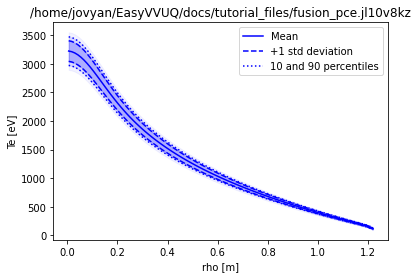

In [21]:
# plot the calculated Te: mean, with std deviation, 10 and 90% and range
plt.figure() 
plt.plot(rho, results.describe('te', 'mean'), 'b-', label='Mean')
plt.plot(rho, results.describe('te', 'mean')-results.describe('te', 'std'), 'b--', label='+1 std deviation')
plt.plot(rho, results.describe('te', 'mean')+results.describe('te', 'std'), 'b--')
plt.fill_between(rho, results.describe('te', 'mean')-results.describe('te', 'std'), results.describe('te', 'mean')+results.describe('te', 'std'), color='b', alpha=0.2)
plt.plot(rho, results.describe('te', '10%'), 'b:', label='10 and 90 percentiles')
plt.plot(rho, results.describe('te', '90%'), 'b:')
plt.fill_between(rho, results.describe('te', '10%'), results.describe('te', '90%'), color='b', alpha=0.1)
plt.fill_between(rho, results.describe('te', 'min'), results.describe('te', 'max'), color='b', alpha=0.05)
plt.legend(loc=0)
plt.xlabel('rho [m]')
plt.ylabel('Te [eV]')
plt.title(my_campaign.campaign_dir);

In [ ]:
# plot the first Sobol results

%matplotlib inline
plt.figure() 
for k in sobols.keys(): plt.plot(rho, sobols[k][0], label=k)
plt.legend(loc=0)
plt.xlabel('rho [m]')
plt.ylabel('sobols_first')
plt.title(my_campaign.campaign_dir)

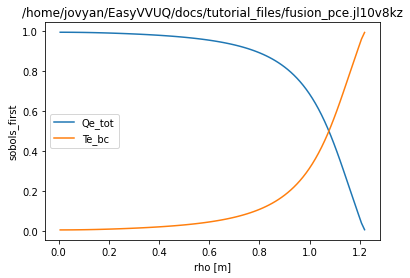

In [22]:
# plot the first Sobol results

plt.figure() 
for k in results.sobols_first()['te'].keys(): plt.plot(rho, results.sobols_first()['te'][k], label=k)
plt.legend(loc=0)
plt.xlabel('rho [m]')
plt.ylabel('sobols_first')
plt.title(my_campaign.campaign_dir);

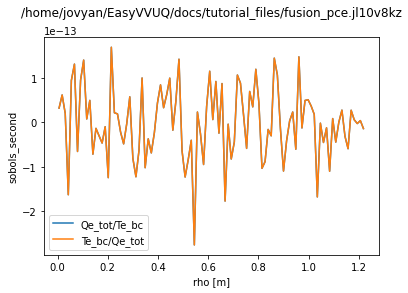

In [23]:
# plot the second Sobol results

plt.figure() 
for k1 in results.sobols_second()['te'].keys(): 
    for k2 in results.sobols_second()['te'][k1].keys():
        plt.plot(rho, results.sobols_second()['te'][k1][k2], label=k1+'/'+k2)
plt.legend(loc=0)    
plt.xlabel('rho [m]')
plt.ylabel('sobols_second')
plt.title(my_campaign.campaign_dir+'\n');

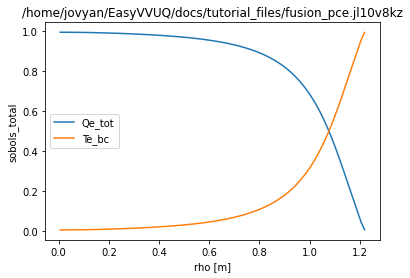

In [24]:
# plot the total Sobol results

plt.figure() 
for k in results.sobols_total()['te'].keys(): plt.plot(rho, results.sobols_total()['te'][k], label=k)
plt.legend(loc=0)    
plt.xlabel('rho [m]')
plt.ylabel('sobols_total')
plt.title(my_campaign.campaign_dir);

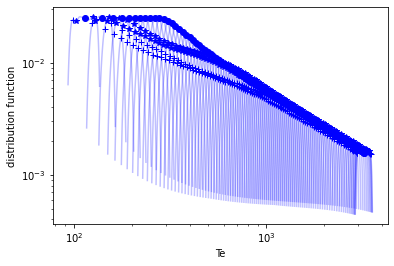

In [25]:
# plot the distributions

plt.figure() 
for i, D in enumerate(results.raw_data['output_distributions']['te']):
    _Te = np.linspace(D.lower[0], D.upper[0], 101)
    _DF = D.pdf(_Te)
    plt.loglog(_Te, _DF, 'b-', alpha=0.25)
    plt.loglog(results.describe('te', 'mean')[i], np.interp(results.describe('te', 'mean')[i], _Te, _DF), 'bo')
    plt.loglog(results.describe('te', 'mean')[i]-results.describe('te', 'std')[i], np.interp(results.describe('te', 'mean')[i]-results.describe('te', 'std')[i], _Te, _DF), 'b*')
    plt.loglog(results.describe('te', 'mean')[i]+results.describe('te', 'std')[i], np.interp(results.describe('te', 'mean')[i]+results.describe('te', 'std')[i], _Te, _DF), 'b*')
    plt.loglog(results.describe('te', '10%')[i],  np.interp(results.describe('te', '10%')[i], _Te, _DF), 'b+')
    plt.loglog(results.describe('te', '90%')[i],  np.interp(results.describe('te', '90%')[i], _Te, _DF), 'b+')
plt.xlabel('Te')
plt.ylabel('distribution function');